<a href="https://colab.research.google.com/github/mrshamshir/Automated-Neurological-Disease-Classification/blob/main/ResNet_V4_grad_CAM_V2(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and data loading

In [ ]:
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path to train datasets and labels

train_rCBF = Path("/content/drive/MyDrive/Assignment/training_images_rcbf.nii")
train_DAT = Path("/content/drive/MyDrive/Assignment/training_images_sbr.nii")

labels = pd.read_csv("/content/drive/MyDrive/Assignment/Diagnoses_of_training_data.csv")

In [ ]:
# Load NIfTI and extract image data
train_PET_rCBF = nib.load(train_rCBF)
train_data_rCBF = train_PET_rCBF.get_fdata()

train_PET_DAT = nib.load(train_DAT)
train_data_DAT = train_PET_DAT.get_fdata()

### Dataset Creation

#### Split data to train, validation, test

In [ ]:
def create_xdata(rCBF, DAT):
    # combine two images of same subjects
    res = np.stack((rCBF, DAT), axis = 3)
    res = np.transpose(res, (4, 3, 0, 1, 2))
    return res

xdata = create_xdata(train_data_rCBF, train_data_DAT)
print(xdata.shape)

(40, 2, 64, 64, 64)


In [ ]:
# Split the dataset into training and validation sets with 80% for training
# 10% for validation, 10% for test, preserving class distribution.

X_train, X_test, y_train, y_test = train_test_split(xdata,
                                                    np.array(labels['diagnose']),
                                                    test_size=0.2, random_state=13,
                                                    stratify=labels['diagnose'])

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5, random_state=13,
                                                    stratify=y_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(32, 2, 64, 64, 64)
(32,)
(4, 2, 64, 64, 64)
(4,)
(4, 2, 64, 64, 64)
(4,)


#### Normalize, augmentation, dataloader

In [ ]:
def calculate_mean_std(data):
    """
        Calculate the mean and standard deviation for each channel across all samples in the input data.

        Args:
        - data (numpy.ndarray): Input data with shape (num_samples, num_channels, depth, height, width).

        Returns:
        - mean (numpy.ndarray): Mean values for each channel across all samples, with shape (num_channels,).
        - std (numpy.ndarray): Standard deviation for each channel across all samples, with shape (num_channels,).
    """
    mean = np.mean(data, axis=(0, 2, 3, 4))
    std = np.std(data, axis=(0, 2, 3, 4))
    return mean, std



mean, std = calculate_mean_std(X_train)
print("Mean for each channel:", mean)
print("Standard deviation for each channel:", std)

Mean for each channel: [12.47252238  2.99483979]
Standard deviation for each channel: [26.93098671 17.29476661]


In [ ]:
# Custom transformation to convert numpy array to tensor
class ToTensor(object):
    def __call__(self, sample):
        return torch.from_numpy(sample).float()  # Convert to float tensor


class Normalize3D(torch.nn.Module):
    def __init__(self, mean, std, inplace=False):
        """
            Initializes the 3D normalization module.

            Args:
            - mean (array-like): Mean values for each channel.
            - std (array-like): Standard deviation values for each channel.
            - inplace (bool): If True, normalize the tensor in-place. Default is False.
        """
        super().__init__()
        self.mean = torch.tensor(mean, dtype=torch.float32).view(-1, 1, 1, 1)
        self.std = torch.tensor(std, dtype=torch.float32).view(-1, 1, 1, 1)
        self.inplace = inplace

    def forward(self, tensor: Tensor) -> Tensor:
        """
            Forward pass of the normalization module.

            Args:
            - tensor (Tensor): Input tensor to be normalized.

            Returns:
            - Tensor: Normalized output tensor.
        """
        if self.inplace:
            tensor.sub_(self.mean).div_(self.std)
            return tensor
        else:
            return (tensor - self.mean) / self.std

    def __repr__(self) -> str:
        """
            Returns a string representation of the normalization module.

            Returns:
            - str: String representation of the module.
        """
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"



In [ ]:
# Define transformations for data augmentation (train) and validation
train_transforms = transforms.Compose([
    ToTensor(),
    Normalize3D(mean, std),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),

])

val_transforms = transforms.Compose([
    ToTensor(),
    Normalize3D(mean, std)
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
            Custom dataset class for handling input data and labels.

            Args:
            - data (array-like): Input data array.
            - labels (array-like): Labels array corresponding to the input data.
            - transform (callable, optional): Optional transform to be applied to the input data.

        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
            Returns the length of the dataset.

            Returns:
            - int: Length of the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
            Retrieves an item from the dataset based on the provided index.

            Args:
            - idx (int): Index of the item to retrieve.

            Returns:
            - dict: A dictionary containing the input data and its corresponding label.
        """
        sample = {'input': self.data[idx], 'label': self.labels[idx] - 1}
        if self.transform:
            sample['input'] = self.transform(sample['input'])
        return sample


In [ ]:
# Create custom datasets with transformations
train_dataset = CustomDataset(X_train, y_train, transform=train_transforms)
val_dataset = CustomDataset(X_val, y_val, transform=val_transforms)  # Apply validation transformation
test_dataset = CustomDataset(X_test, y_test, transform=val_transforms)  # Apply validation transformation

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images and {len(test_dataset)} test images")

There are 32 train images and 4 val images and 4 test images


In [ ]:
print('train dataset', np.unique(train_dataset.labels, return_counts=True))
print('val dataset', np.unique(val_dataset.labels, return_counts=True))
print('test dataset', np.unique(test_dataset.labels, return_counts=True))

train dataset (array([1, 2, 3, 4]), array([8, 8, 8, 8]))
val dataset (array([1, 2, 3, 4]), array([1, 1, 1, 1]))
test dataset (array([1, 2, 3, 4]), array([1, 1, 1, 1]))


In [ ]:
# Define batch size and number of workers
batch_size = 2
num_workers = 0

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Model creation

In [ ]:
class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=4, zero_init_residual=False):
        super(ResNet3D, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv3d(2, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)  # Change input channels to 64
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock3D):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


    def grad_eval(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        x5 = self.avgpool(x4)
        x5 = torch.flatten(x5, 1)
        x = self.fc(x5)

        return [x1,x2,x3,x4,x5],x


### Train and evaluation

#### Train
 lr=0.0002, SGD optimizer and CyclicLR Learning rate scheduler

In [ ]:
path_to_save = '/content'

# Initialize the model
model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=4)

# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0002, max_lr=0.002,step_size_up=100,mode="exp_range",gamma=0.99)

criterion = nn.CrossEntropyLoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_losses = []
validation_losses = []
test_losses=[]

# Training loop
num_epochs = 200  # Adjust the number of epochs as needed
min_val_loss=np.inf
best_val_epoch_num=0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, batch in enumerate(tqdm(train_loader)):
        inputs, labels = batch['input'].to(device), batch['label'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

        # Print statistics
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)

    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['input'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    validation_loss = running_val_loss / len(val_loader)
    validation_losses.append(validation_loss)

    test_correct = 0
    test_total = 0
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['input'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    test_loss = running_test_loss / len(test_loader)
    test_losses.append(test_loss)

    # Print training loss for the epoch
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {running_val_loss / len(val_loader):.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], test Loss: {running_test_loss / len(test_loader):.4f}")


    print(f"Validation Accuracy for Epoch [{epoch + 1}/{num_epochs}]: {100 * correct / total:.2f}%")
    print(f"Test Accuracy for Epoch [{epoch + 1}/{num_epochs}]: {100 * test_correct / test_total:.2f}%")

    if validation_loss<min_val_loss:
      min_val_loss=validation_loss
      best_val_epoch_num=epoch + 1
      with open(f'{path_to_save}/resnet3d_best.pkl', 'wb') as f:
          pickle.dump(model, f)
      print('best model saved to: ',f'{path_to_save}/resnet3d_best.pkl')


print("-----------------------------------------------------------------")
print("Training finished.")
print(f"Best Val epoch number: {best_val_epoch_num}")

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/200], Training Loss: 1.6149
Epoch [1/200], Validation Loss: 1.1968
Epoch [1/200], test Loss: 1.3649
Validation Accuracy for Epoch [1/200]: 25.00%
Test Accuracy for Epoch [1/200]: 25.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/200], Training Loss: 1.3692
Epoch [2/200], Validation Loss: 0.9402
Epoch [2/200], test Loss: 1.2251
Validation Accuracy for Epoch [2/200]: 50.00%
Test Accuracy for Epoch [2/200]: 25.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/200], Training Loss: 1.4800
Epoch [3/200], Validation Loss: 1.1145
Epoch [3/200], test Loss: 1.6098
Validation Accuracy for Epoch [3/200]: 50.00%
Test Accuracy for Epoch [3/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/200], Training Loss: 1.3439
Epoch [4/200], Validation Loss: 0.8701
Epoch [4/200], test Loss: 1.1639
Validation Accuracy for Epoch [4/200]: 25.00%
Test Accuracy for Epoch [4/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/200], Training Loss: 1.2477
Epoch [5/200], Validation Loss: 1.0945
Epoch [5/200], test Loss: 0.8338
Validation Accuracy for Epoch [5/200]: 50.00%
Test Accuracy for Epoch [5/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/200], Training Loss: 1.2635
Epoch [6/200], Validation Loss: 0.8370
Epoch [6/200], test Loss: 0.5497
Validation Accuracy for Epoch [6/200]: 25.00%
Test Accuracy for Epoch [6/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/200], Training Loss: 1.0427
Epoch [7/200], Validation Loss: 0.7129
Epoch [7/200], test Loss: 0.8222
Validation Accuracy for Epoch [7/200]: 75.00%
Test Accuracy for Epoch [7/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/200], Training Loss: 1.0653
Epoch [8/200], Validation Loss: 0.6421
Epoch [8/200], test Loss: 0.8664
Validation Accuracy for Epoch [8/200]: 75.00%
Test Accuracy for Epoch [8/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/200], Training Loss: 0.9569
Epoch [9/200], Validation Loss: 0.8129
Epoch [9/200], test Loss: 0.6229
Validation Accuracy for Epoch [9/200]: 50.00%
Test Accuracy for Epoch [9/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/200], Training Loss: 1.0720
Epoch [10/200], Validation Loss: 0.8151
Epoch [10/200], test Loss: 0.7416
Validation Accuracy for Epoch [10/200]: 75.00%
Test Accuracy for Epoch [10/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/200], Training Loss: 0.7856
Epoch [11/200], Validation Loss: 0.6750
Epoch [11/200], test Loss: 0.6804
Validation Accuracy for Epoch [11/200]: 50.00%
Test Accuracy for Epoch [11/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/200], Training Loss: 0.6508
Epoch [12/200], Validation Loss: 0.6133
Epoch [12/200], test Loss: 0.5877
Validation Accuracy for Epoch [12/200]: 75.00%
Test Accuracy for Epoch [12/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13/200], Training Loss: 0.7867
Epoch [13/200], Validation Loss: 0.5598
Epoch [13/200], test Loss: 0.5279
Validation Accuracy for Epoch [13/200]: 75.00%
Test Accuracy for Epoch [13/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14/200], Training Loss: 0.6353
Epoch [14/200], Validation Loss: 0.5122
Epoch [14/200], test Loss: 0.5055
Validation Accuracy for Epoch [14/200]: 100.00%
Test Accuracy for Epoch [14/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15/200], Training Loss: 0.5454
Epoch [15/200], Validation Loss: 0.5595
Epoch [15/200], test Loss: 0.5233
Validation Accuracy for Epoch [15/200]: 75.00%
Test Accuracy for Epoch [15/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16/200], Training Loss: 0.4754
Epoch [16/200], Validation Loss: 0.5933
Epoch [16/200], test Loss: 0.4367
Validation Accuracy for Epoch [16/200]: 75.00%
Test Accuracy for Epoch [16/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17/200], Training Loss: 0.5670
Epoch [17/200], Validation Loss: 0.5120
Epoch [17/200], test Loss: 0.3366
Validation Accuracy for Epoch [17/200]: 75.00%
Test Accuracy for Epoch [17/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18/200], Training Loss: 0.5276
Epoch [18/200], Validation Loss: 0.4926
Epoch [18/200], test Loss: 0.3714
Validation Accuracy for Epoch [18/200]: 75.00%
Test Accuracy for Epoch [18/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19/200], Training Loss: 0.4768
Epoch [19/200], Validation Loss: 0.4924
Epoch [19/200], test Loss: 0.3523
Validation Accuracy for Epoch [19/200]: 75.00%
Test Accuracy for Epoch [19/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20/200], Training Loss: 0.4438
Epoch [20/200], Validation Loss: 0.4030
Epoch [20/200], test Loss: 0.4052
Validation Accuracy for Epoch [20/200]: 100.00%
Test Accuracy for Epoch [20/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21/200], Training Loss: 0.4911
Epoch [21/200], Validation Loss: 0.3959
Epoch [21/200], test Loss: 0.4626
Validation Accuracy for Epoch [21/200]: 75.00%
Test Accuracy for Epoch [21/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22/200], Training Loss: 0.4042
Epoch [22/200], Validation Loss: 0.3277
Epoch [22/200], test Loss: 0.2886
Validation Accuracy for Epoch [22/200]: 100.00%
Test Accuracy for Epoch [22/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23/200], Training Loss: 0.4574
Epoch [23/200], Validation Loss: 0.3481
Epoch [23/200], test Loss: 0.3164
Validation Accuracy for Epoch [23/200]: 75.00%
Test Accuracy for Epoch [23/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24/200], Training Loss: 0.3631
Epoch [24/200], Validation Loss: 0.3834
Epoch [24/200], test Loss: 0.4898
Validation Accuracy for Epoch [24/200]: 100.00%
Test Accuracy for Epoch [24/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25/200], Training Loss: 0.2445
Epoch [25/200], Validation Loss: 0.3279
Epoch [25/200], test Loss: 0.3088
Validation Accuracy for Epoch [25/200]: 100.00%
Test Accuracy for Epoch [25/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26/200], Training Loss: 0.3480
Epoch [26/200], Validation Loss: 0.3293
Epoch [26/200], test Loss: 0.2723
Validation Accuracy for Epoch [26/200]: 100.00%
Test Accuracy for Epoch [26/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27/200], Training Loss: 0.3055
Epoch [27/200], Validation Loss: 0.3015
Epoch [27/200], test Loss: 0.3388
Validation Accuracy for Epoch [27/200]: 100.00%
Test Accuracy for Epoch [27/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28/200], Training Loss: 0.2068
Epoch [28/200], Validation Loss: 0.3019
Epoch [28/200], test Loss: 0.2402
Validation Accuracy for Epoch [28/200]: 100.00%
Test Accuracy for Epoch [28/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29/200], Training Loss: 0.2300
Epoch [29/200], Validation Loss: 0.3075
Epoch [29/200], test Loss: 0.1977
Validation Accuracy for Epoch [29/200]: 100.00%
Test Accuracy for Epoch [29/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [30/200], Training Loss: 0.1916
Epoch [30/200], Validation Loss: 0.3049
Epoch [30/200], test Loss: 0.1868
Validation Accuracy for Epoch [30/200]: 100.00%
Test Accuracy for Epoch [30/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [31/200], Training Loss: 0.1693
Epoch [31/200], Validation Loss: 0.2698
Epoch [31/200], test Loss: 0.2147
Validation Accuracy for Epoch [31/200]: 100.00%
Test Accuracy for Epoch [31/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [32/200], Training Loss: 0.1237
Epoch [32/200], Validation Loss: 0.3129
Epoch [32/200], test Loss: 0.1962
Validation Accuracy for Epoch [32/200]: 100.00%
Test Accuracy for Epoch [32/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [33/200], Training Loss: 0.2499
Epoch [33/200], Validation Loss: 0.3311
Epoch [33/200], test Loss: 0.1286
Validation Accuracy for Epoch [33/200]: 100.00%
Test Accuracy for Epoch [33/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [34/200], Training Loss: 0.2327
Epoch [34/200], Validation Loss: 0.2744
Epoch [34/200], test Loss: 0.1130
Validation Accuracy for Epoch [34/200]: 100.00%
Test Accuracy for Epoch [34/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [35/200], Training Loss: 0.1242
Epoch [35/200], Validation Loss: 0.2339
Epoch [35/200], test Loss: 0.1251
Validation Accuracy for Epoch [35/200]: 100.00%
Test Accuracy for Epoch [35/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [36/200], Training Loss: 0.0904
Epoch [36/200], Validation Loss: 0.2320
Epoch [36/200], test Loss: 0.1905
Validation Accuracy for Epoch [36/200]: 100.00%
Test Accuracy for Epoch [36/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [37/200], Training Loss: 0.1121
Epoch [37/200], Validation Loss: 0.2459
Epoch [37/200], test Loss: 0.1180
Validation Accuracy for Epoch [37/200]: 100.00%
Test Accuracy for Epoch [37/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [38/200], Training Loss: 0.1381
Epoch [38/200], Validation Loss: 0.2059
Epoch [38/200], test Loss: 0.2094
Validation Accuracy for Epoch [38/200]: 100.00%
Test Accuracy for Epoch [38/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [39/200], Training Loss: 0.2273
Epoch [39/200], Validation Loss: 0.3301
Epoch [39/200], test Loss: 0.2326
Validation Accuracy for Epoch [39/200]: 75.00%
Test Accuracy for Epoch [39/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [40/200], Training Loss: 0.1302
Epoch [40/200], Validation Loss: 0.2612
Epoch [40/200], test Loss: 0.1874
Validation Accuracy for Epoch [40/200]: 100.00%
Test Accuracy for Epoch [40/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [41/200], Training Loss: 0.2171
Epoch [41/200], Validation Loss: 0.3021
Epoch [41/200], test Loss: 0.3608
Validation Accuracy for Epoch [41/200]: 75.00%
Test Accuracy for Epoch [41/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [42/200], Training Loss: 0.1458
Epoch [42/200], Validation Loss: 0.2569
Epoch [42/200], test Loss: 0.2625
Validation Accuracy for Epoch [42/200]: 100.00%
Test Accuracy for Epoch [42/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [43/200], Training Loss: 0.1898
Epoch [43/200], Validation Loss: 0.2689
Epoch [43/200], test Loss: 0.2680
Validation Accuracy for Epoch [43/200]: 100.00%
Test Accuracy for Epoch [43/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [44/200], Training Loss: 0.1377
Epoch [44/200], Validation Loss: 0.2604
Epoch [44/200], test Loss: 0.1609
Validation Accuracy for Epoch [44/200]: 100.00%
Test Accuracy for Epoch [44/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [45/200], Training Loss: 0.1535
Epoch [45/200], Validation Loss: 0.2751
Epoch [45/200], test Loss: 0.1178
Validation Accuracy for Epoch [45/200]: 75.00%
Test Accuracy for Epoch [45/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [46/200], Training Loss: 0.1114
Epoch [46/200], Validation Loss: 0.2258
Epoch [46/200], test Loss: 0.1751
Validation Accuracy for Epoch [46/200]: 100.00%
Test Accuracy for Epoch [46/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [47/200], Training Loss: 0.1651
Epoch [47/200], Validation Loss: 0.2590
Epoch [47/200], test Loss: 0.2216
Validation Accuracy for Epoch [47/200]: 75.00%
Test Accuracy for Epoch [47/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [48/200], Training Loss: 0.1736
Epoch [48/200], Validation Loss: 0.3075
Epoch [48/200], test Loss: 0.4321
Validation Accuracy for Epoch [48/200]: 100.00%
Test Accuracy for Epoch [48/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [49/200], Training Loss: 0.1239
Epoch [49/200], Validation Loss: 0.4078
Epoch [49/200], test Loss: 0.2279
Validation Accuracy for Epoch [49/200]: 75.00%
Test Accuracy for Epoch [49/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [50/200], Training Loss: 0.1019
Epoch [50/200], Validation Loss: 0.3142
Epoch [50/200], test Loss: 0.1375
Validation Accuracy for Epoch [50/200]: 75.00%
Test Accuracy for Epoch [50/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [51/200], Training Loss: 0.0762
Epoch [51/200], Validation Loss: 0.2208
Epoch [51/200], test Loss: 0.1602
Validation Accuracy for Epoch [51/200]: 100.00%
Test Accuracy for Epoch [51/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [52/200], Training Loss: 0.1822
Epoch [52/200], Validation Loss: 0.2624
Epoch [52/200], test Loss: 0.1444
Validation Accuracy for Epoch [52/200]: 75.00%
Test Accuracy for Epoch [52/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [53/200], Training Loss: 0.1153
Epoch [53/200], Validation Loss: 0.3168
Epoch [53/200], test Loss: 0.1367
Validation Accuracy for Epoch [53/200]: 100.00%
Test Accuracy for Epoch [53/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [54/200], Training Loss: 0.1619
Epoch [54/200], Validation Loss: 0.2897
Epoch [54/200], test Loss: 0.0653
Validation Accuracy for Epoch [54/200]: 75.00%
Test Accuracy for Epoch [54/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [55/200], Training Loss: 0.0879
Epoch [55/200], Validation Loss: 0.1674
Epoch [55/200], test Loss: 0.0926
Validation Accuracy for Epoch [55/200]: 100.00%
Test Accuracy for Epoch [55/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [56/200], Training Loss: 0.1145
Epoch [56/200], Validation Loss: 0.1879
Epoch [56/200], test Loss: 0.0902
Validation Accuracy for Epoch [56/200]: 100.00%
Test Accuracy for Epoch [56/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [57/200], Training Loss: 0.1373
Epoch [57/200], Validation Loss: 0.4319
Epoch [57/200], test Loss: 0.2507
Validation Accuracy for Epoch [57/200]: 75.00%
Test Accuracy for Epoch [57/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [58/200], Training Loss: 0.1791
Epoch [58/200], Validation Loss: 0.3272
Epoch [58/200], test Loss: 0.2314
Validation Accuracy for Epoch [58/200]: 75.00%
Test Accuracy for Epoch [58/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [59/200], Training Loss: 0.1664
Epoch [59/200], Validation Loss: 0.3584
Epoch [59/200], test Loss: 0.1336
Validation Accuracy for Epoch [59/200]: 75.00%
Test Accuracy for Epoch [59/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [60/200], Training Loss: 0.0860
Epoch [60/200], Validation Loss: 0.2812
Epoch [60/200], test Loss: 0.1682
Validation Accuracy for Epoch [60/200]: 100.00%
Test Accuracy for Epoch [60/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [61/200], Training Loss: 0.1017
Epoch [61/200], Validation Loss: 0.4182
Epoch [61/200], test Loss: 0.4767
Validation Accuracy for Epoch [61/200]: 75.00%
Test Accuracy for Epoch [61/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [62/200], Training Loss: 0.1235
Epoch [62/200], Validation Loss: 0.2060
Epoch [62/200], test Loss: 0.1722
Validation Accuracy for Epoch [62/200]: 100.00%
Test Accuracy for Epoch [62/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [63/200], Training Loss: 0.1533
Epoch [63/200], Validation Loss: 0.4059
Epoch [63/200], test Loss: 0.2184
Validation Accuracy for Epoch [63/200]: 75.00%
Test Accuracy for Epoch [63/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [64/200], Training Loss: 0.0802
Epoch [64/200], Validation Loss: 0.2309
Epoch [64/200], test Loss: 0.1709
Validation Accuracy for Epoch [64/200]: 100.00%
Test Accuracy for Epoch [64/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [65/200], Training Loss: 0.1915
Epoch [65/200], Validation Loss: 0.2768
Epoch [65/200], test Loss: 0.1899
Validation Accuracy for Epoch [65/200]: 75.00%
Test Accuracy for Epoch [65/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [66/200], Training Loss: 0.1008
Epoch [66/200], Validation Loss: 0.2942
Epoch [66/200], test Loss: 0.4384
Validation Accuracy for Epoch [66/200]: 75.00%
Test Accuracy for Epoch [66/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [67/200], Training Loss: 0.0574
Epoch [67/200], Validation Loss: 0.5332
Epoch [67/200], test Loss: 0.1868
Validation Accuracy for Epoch [67/200]: 75.00%
Test Accuracy for Epoch [67/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [68/200], Training Loss: 0.1107
Epoch [68/200], Validation Loss: 0.4149
Epoch [68/200], test Loss: 0.1117
Validation Accuracy for Epoch [68/200]: 75.00%
Test Accuracy for Epoch [68/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [69/200], Training Loss: 0.0282
Epoch [69/200], Validation Loss: 0.2970
Epoch [69/200], test Loss: 0.1169
Validation Accuracy for Epoch [69/200]: 75.00%
Test Accuracy for Epoch [69/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [70/200], Training Loss: 0.0476
Epoch [70/200], Validation Loss: 0.2481
Epoch [70/200], test Loss: 0.1470
Validation Accuracy for Epoch [70/200]: 75.00%
Test Accuracy for Epoch [70/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [71/200], Training Loss: 0.1086
Epoch [71/200], Validation Loss: 0.2423
Epoch [71/200], test Loss: 0.1898
Validation Accuracy for Epoch [71/200]: 75.00%
Test Accuracy for Epoch [71/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [72/200], Training Loss: 0.0777
Epoch [72/200], Validation Loss: 0.1862
Epoch [72/200], test Loss: 0.1110
Validation Accuracy for Epoch [72/200]: 100.00%
Test Accuracy for Epoch [72/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [73/200], Training Loss: 0.1414
Epoch [73/200], Validation Loss: 0.1802
Epoch [73/200], test Loss: 0.1112
Validation Accuracy for Epoch [73/200]: 100.00%
Test Accuracy for Epoch [73/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [74/200], Training Loss: 0.0767
Epoch [74/200], Validation Loss: 0.3180
Epoch [74/200], test Loss: 0.4304
Validation Accuracy for Epoch [74/200]: 75.00%
Test Accuracy for Epoch [74/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [75/200], Training Loss: 0.0556
Epoch [75/200], Validation Loss: 0.1725
Epoch [75/200], test Loss: 0.1786
Validation Accuracy for Epoch [75/200]: 100.00%
Test Accuracy for Epoch [75/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [76/200], Training Loss: 0.0613
Epoch [76/200], Validation Loss: 0.1656
Epoch [76/200], test Loss: 0.0759
Validation Accuracy for Epoch [76/200]: 100.00%
Test Accuracy for Epoch [76/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [77/200], Training Loss: 0.0799
Epoch [77/200], Validation Loss: 0.1891
Epoch [77/200], test Loss: 0.1221
Validation Accuracy for Epoch [77/200]: 100.00%
Test Accuracy for Epoch [77/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [78/200], Training Loss: 0.1023
Epoch [78/200], Validation Loss: 0.1729
Epoch [78/200], test Loss: 0.1325
Validation Accuracy for Epoch [78/200]: 100.00%
Test Accuracy for Epoch [78/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [79/200], Training Loss: 0.0561
Epoch [79/200], Validation Loss: 0.2450
Epoch [79/200], test Loss: 0.1431
Validation Accuracy for Epoch [79/200]: 75.00%
Test Accuracy for Epoch [79/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [80/200], Training Loss: 0.0529
Epoch [80/200], Validation Loss: 0.3248
Epoch [80/200], test Loss: 0.2746
Validation Accuracy for Epoch [80/200]: 75.00%
Test Accuracy for Epoch [80/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [81/200], Training Loss: 0.0570
Epoch [81/200], Validation Loss: 0.2117
Epoch [81/200], test Loss: 0.2817
Validation Accuracy for Epoch [81/200]: 100.00%
Test Accuracy for Epoch [81/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [82/200], Training Loss: 0.0403
Epoch [82/200], Validation Loss: 0.2082
Epoch [82/200], test Loss: 0.2299
Validation Accuracy for Epoch [82/200]: 100.00%
Test Accuracy for Epoch [82/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [83/200], Training Loss: 0.0423
Epoch [83/200], Validation Loss: 0.1878
Epoch [83/200], test Loss: 0.1949
Validation Accuracy for Epoch [83/200]: 100.00%
Test Accuracy for Epoch [83/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [84/200], Training Loss: 0.0484
Epoch [84/200], Validation Loss: 0.2190
Epoch [84/200], test Loss: 0.1944
Validation Accuracy for Epoch [84/200]: 100.00%
Test Accuracy for Epoch [84/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [85/200], Training Loss: 0.0156
Epoch [85/200], Validation Loss: 0.1666
Epoch [85/200], test Loss: 0.1630
Validation Accuracy for Epoch [85/200]: 100.00%
Test Accuracy for Epoch [85/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [86/200], Training Loss: 0.0270
Epoch [86/200], Validation Loss: 0.1598
Epoch [86/200], test Loss: 0.1386
Validation Accuracy for Epoch [86/200]: 100.00%
Test Accuracy for Epoch [86/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [87/200], Training Loss: 0.0592
Epoch [87/200], Validation Loss: 0.1742
Epoch [87/200], test Loss: 0.1483
Validation Accuracy for Epoch [87/200]: 100.00%
Test Accuracy for Epoch [87/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [88/200], Training Loss: 0.0674
Epoch [88/200], Validation Loss: 0.2174
Epoch [88/200], test Loss: 0.1425
Validation Accuracy for Epoch [88/200]: 100.00%
Test Accuracy for Epoch [88/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [89/200], Training Loss: 0.0515
Epoch [89/200], Validation Loss: 0.1791
Epoch [89/200], test Loss: 0.1017
Validation Accuracy for Epoch [89/200]: 100.00%
Test Accuracy for Epoch [89/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [90/200], Training Loss: 0.0670
Epoch [90/200], Validation Loss: 0.2513
Epoch [90/200], test Loss: 0.1205
Validation Accuracy for Epoch [90/200]: 100.00%
Test Accuracy for Epoch [90/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [91/200], Training Loss: 0.0429
Epoch [91/200], Validation Loss: 0.1714
Epoch [91/200], test Loss: 0.0698
Validation Accuracy for Epoch [91/200]: 100.00%
Test Accuracy for Epoch [91/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [92/200], Training Loss: 0.0319
Epoch [92/200], Validation Loss: 0.2138
Epoch [92/200], test Loss: 0.1658
Validation Accuracy for Epoch [92/200]: 100.00%
Test Accuracy for Epoch [92/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [93/200], Training Loss: 0.0392
Epoch [93/200], Validation Loss: 0.1972
Epoch [93/200], test Loss: 0.1560
Validation Accuracy for Epoch [93/200]: 100.00%
Test Accuracy for Epoch [93/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [94/200], Training Loss: 0.0327
Epoch [94/200], Validation Loss: 0.1883
Epoch [94/200], test Loss: 0.2124
Validation Accuracy for Epoch [94/200]: 100.00%
Test Accuracy for Epoch [94/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [95/200], Training Loss: 0.0304
Epoch [95/200], Validation Loss: 0.1573
Epoch [95/200], test Loss: 0.2370
Validation Accuracy for Epoch [95/200]: 100.00%
Test Accuracy for Epoch [95/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [96/200], Training Loss: 0.0172
Epoch [96/200], Validation Loss: 0.1415
Epoch [96/200], test Loss: 0.1950
Validation Accuracy for Epoch [96/200]: 100.00%
Test Accuracy for Epoch [96/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [97/200], Training Loss: 0.0456
Epoch [97/200], Validation Loss: 0.1654
Epoch [97/200], test Loss: 0.1238
Validation Accuracy for Epoch [97/200]: 100.00%
Test Accuracy for Epoch [97/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [98/200], Training Loss: 0.0174
Epoch [98/200], Validation Loss: 0.2099
Epoch [98/200], test Loss: 0.1127
Validation Accuracy for Epoch [98/200]: 100.00%
Test Accuracy for Epoch [98/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [99/200], Training Loss: 0.0275
Epoch [99/200], Validation Loss: 0.2163
Epoch [99/200], test Loss: 0.1196
Validation Accuracy for Epoch [99/200]: 100.00%
Test Accuracy for Epoch [99/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [100/200], Training Loss: 0.0394
Epoch [100/200], Validation Loss: 0.4206
Epoch [100/200], test Loss: 0.2148
Validation Accuracy for Epoch [100/200]: 75.00%
Test Accuracy for Epoch [100/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [101/200], Training Loss: 0.0179
Epoch [101/200], Validation Loss: 0.3847
Epoch [101/200], test Loss: 0.2042
Validation Accuracy for Epoch [101/200]: 75.00%
Test Accuracy for Epoch [101/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [102/200], Training Loss: 0.0233
Epoch [102/200], Validation Loss: 0.3288
Epoch [102/200], test Loss: 0.1918
Validation Accuracy for Epoch [102/200]: 75.00%
Test Accuracy for Epoch [102/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [103/200], Training Loss: 0.0446
Epoch [103/200], Validation Loss: 0.3271
Epoch [103/200], test Loss: 0.1165
Validation Accuracy for Epoch [103/200]: 75.00%
Test Accuracy for Epoch [103/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [104/200], Training Loss: 0.0276
Epoch [104/200], Validation Loss: 0.3563
Epoch [104/200], test Loss: 0.1797
Validation Accuracy for Epoch [104/200]: 75.00%
Test Accuracy for Epoch [104/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [105/200], Training Loss: 0.0158
Epoch [105/200], Validation Loss: 0.3925
Epoch [105/200], test Loss: 0.1680
Validation Accuracy for Epoch [105/200]: 75.00%
Test Accuracy for Epoch [105/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [106/200], Training Loss: 0.0355
Epoch [106/200], Validation Loss: 0.3125
Epoch [106/200], test Loss: 0.0716
Validation Accuracy for Epoch [106/200]: 75.00%
Test Accuracy for Epoch [106/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [107/200], Training Loss: 0.0264
Epoch [107/200], Validation Loss: 0.3089
Epoch [107/200], test Loss: 0.1048
Validation Accuracy for Epoch [107/200]: 75.00%
Test Accuracy for Epoch [107/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [108/200], Training Loss: 0.0248
Epoch [108/200], Validation Loss: 0.2033
Epoch [108/200], test Loss: 0.0824
Validation Accuracy for Epoch [108/200]: 100.00%
Test Accuracy for Epoch [108/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [109/200], Training Loss: 0.0092
Epoch [109/200], Validation Loss: 0.1849
Epoch [109/200], test Loss: 0.0881
Validation Accuracy for Epoch [109/200]: 100.00%
Test Accuracy for Epoch [109/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [110/200], Training Loss: 0.0231
Epoch [110/200], Validation Loss: 0.2198
Epoch [110/200], test Loss: 0.1146
Validation Accuracy for Epoch [110/200]: 75.00%
Test Accuracy for Epoch [110/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [111/200], Training Loss: 0.0216
Epoch [111/200], Validation Loss: 0.2343
Epoch [111/200], test Loss: 0.1027
Validation Accuracy for Epoch [111/200]: 75.00%
Test Accuracy for Epoch [111/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [112/200], Training Loss: 0.0142
Epoch [112/200], Validation Loss: 0.3202
Epoch [112/200], test Loss: 0.1568
Validation Accuracy for Epoch [112/200]: 75.00%
Test Accuracy for Epoch [112/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [113/200], Training Loss: 0.0577
Epoch [113/200], Validation Loss: 0.1444
Epoch [113/200], test Loss: 0.0834
Validation Accuracy for Epoch [113/200]: 100.00%
Test Accuracy for Epoch [113/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [114/200], Training Loss: 0.0278
Epoch [114/200], Validation Loss: 0.1077
Epoch [114/200], test Loss: 0.1072
Validation Accuracy for Epoch [114/200]: 100.00%
Test Accuracy for Epoch [114/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [115/200], Training Loss: 0.0297
Epoch [115/200], Validation Loss: 0.1523
Epoch [115/200], test Loss: 0.1322
Validation Accuracy for Epoch [115/200]: 100.00%
Test Accuracy for Epoch [115/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [116/200], Training Loss: 0.0321
Epoch [116/200], Validation Loss: 0.1530
Epoch [116/200], test Loss: 0.1293
Validation Accuracy for Epoch [116/200]: 100.00%
Test Accuracy for Epoch [116/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [117/200], Training Loss: 0.0204
Epoch [117/200], Validation Loss: 0.1571
Epoch [117/200], test Loss: 0.1017
Validation Accuracy for Epoch [117/200]: 100.00%
Test Accuracy for Epoch [117/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [118/200], Training Loss: 0.0246
Epoch [118/200], Validation Loss: 0.1615
Epoch [118/200], test Loss: 0.1522
Validation Accuracy for Epoch [118/200]: 100.00%
Test Accuracy for Epoch [118/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [119/200], Training Loss: 0.0212
Epoch [119/200], Validation Loss: 0.1302
Epoch [119/200], test Loss: 0.1090
Validation Accuracy for Epoch [119/200]: 100.00%
Test Accuracy for Epoch [119/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [120/200], Training Loss: 0.0347
Epoch [120/200], Validation Loss: 0.2411
Epoch [120/200], test Loss: 0.1687
Validation Accuracy for Epoch [120/200]: 75.00%
Test Accuracy for Epoch [120/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [121/200], Training Loss: 0.0572
Epoch [121/200], Validation Loss: 0.1763
Epoch [121/200], test Loss: 0.0701
Validation Accuracy for Epoch [121/200]: 100.00%
Test Accuracy for Epoch [121/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [122/200], Training Loss: 0.0336
Epoch [122/200], Validation Loss: 0.1599
Epoch [122/200], test Loss: 0.1588
Validation Accuracy for Epoch [122/200]: 100.00%
Test Accuracy for Epoch [122/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [123/200], Training Loss: 0.2460
Epoch [123/200], Validation Loss: 0.3663
Epoch [123/200], test Loss: 0.3427
Validation Accuracy for Epoch [123/200]: 75.00%
Test Accuracy for Epoch [123/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [124/200], Training Loss: 0.0161
Epoch [124/200], Validation Loss: 0.4091
Epoch [124/200], test Loss: 0.3989
Validation Accuracy for Epoch [124/200]: 75.00%
Test Accuracy for Epoch [124/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [125/200], Training Loss: 0.0623
Epoch [125/200], Validation Loss: 0.3049
Epoch [125/200], test Loss: 0.2116
Validation Accuracy for Epoch [125/200]: 75.00%
Test Accuracy for Epoch [125/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [126/200], Training Loss: 0.0292
Epoch [126/200], Validation Loss: 0.2872
Epoch [126/200], test Loss: 0.1257
Validation Accuracy for Epoch [126/200]: 75.00%
Test Accuracy for Epoch [126/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [127/200], Training Loss: 0.0856
Epoch [127/200], Validation Loss: 0.2650
Epoch [127/200], test Loss: 0.1295
Validation Accuracy for Epoch [127/200]: 100.00%
Test Accuracy for Epoch [127/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [128/200], Training Loss: 0.0338
Epoch [128/200], Validation Loss: 0.4308
Epoch [128/200], test Loss: 0.2461
Validation Accuracy for Epoch [128/200]: 75.00%
Test Accuracy for Epoch [128/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [129/200], Training Loss: 0.0257
Epoch [129/200], Validation Loss: 0.3891
Epoch [129/200], test Loss: 0.1268
Validation Accuracy for Epoch [129/200]: 75.00%
Test Accuracy for Epoch [129/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [130/200], Training Loss: 0.0337
Epoch [130/200], Validation Loss: 0.3874
Epoch [130/200], test Loss: 0.1153
Validation Accuracy for Epoch [130/200]: 75.00%
Test Accuracy for Epoch [130/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [131/200], Training Loss: 0.0489
Epoch [131/200], Validation Loss: 0.5730
Epoch [131/200], test Loss: 0.3343
Validation Accuracy for Epoch [131/200]: 75.00%
Test Accuracy for Epoch [131/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [132/200], Training Loss: 0.0238
Epoch [132/200], Validation Loss: 0.3815
Epoch [132/200], test Loss: 0.1577
Validation Accuracy for Epoch [132/200]: 75.00%
Test Accuracy for Epoch [132/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [133/200], Training Loss: 0.0269
Epoch [133/200], Validation Loss: 0.4063
Epoch [133/200], test Loss: 0.1119
Validation Accuracy for Epoch [133/200]: 75.00%
Test Accuracy for Epoch [133/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [134/200], Training Loss: 0.0094
Epoch [134/200], Validation Loss: 0.3123
Epoch [134/200], test Loss: 0.0707
Validation Accuracy for Epoch [134/200]: 75.00%
Test Accuracy for Epoch [134/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [135/200], Training Loss: 0.0257
Epoch [135/200], Validation Loss: 0.4021
Epoch [135/200], test Loss: 0.1023
Validation Accuracy for Epoch [135/200]: 75.00%
Test Accuracy for Epoch [135/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [136/200], Training Loss: 0.0783
Epoch [136/200], Validation Loss: 0.4533
Epoch [136/200], test Loss: 0.0623
Validation Accuracy for Epoch [136/200]: 75.00%
Test Accuracy for Epoch [136/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [137/200], Training Loss: 0.0685
Epoch [137/200], Validation Loss: 0.4089
Epoch [137/200], test Loss: 0.0997
Validation Accuracy for Epoch [137/200]: 75.00%
Test Accuracy for Epoch [137/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [138/200], Training Loss: 0.0165
Epoch [138/200], Validation Loss: 0.4097
Epoch [138/200], test Loss: 0.1825
Validation Accuracy for Epoch [138/200]: 75.00%
Test Accuracy for Epoch [138/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [139/200], Training Loss: 0.0365
Epoch [139/200], Validation Loss: 0.3230
Epoch [139/200], test Loss: 0.0822
Validation Accuracy for Epoch [139/200]: 75.00%
Test Accuracy for Epoch [139/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [140/200], Training Loss: 0.0243
Epoch [140/200], Validation Loss: 0.2494
Epoch [140/200], test Loss: 0.0844
Validation Accuracy for Epoch [140/200]: 100.00%
Test Accuracy for Epoch [140/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [141/200], Training Loss: 0.0129
Epoch [141/200], Validation Loss: 0.3980
Epoch [141/200], test Loss: 0.1001
Validation Accuracy for Epoch [141/200]: 75.00%
Test Accuracy for Epoch [141/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [142/200], Training Loss: 0.0120
Epoch [142/200], Validation Loss: 0.5056
Epoch [142/200], test Loss: 0.0947
Validation Accuracy for Epoch [142/200]: 75.00%
Test Accuracy for Epoch [142/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [143/200], Training Loss: 0.0165
Epoch [143/200], Validation Loss: 0.3930
Epoch [143/200], test Loss: 0.0595
Validation Accuracy for Epoch [143/200]: 75.00%
Test Accuracy for Epoch [143/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [144/200], Training Loss: 0.0160
Epoch [144/200], Validation Loss: 0.5796
Epoch [144/200], test Loss: 0.0937
Validation Accuracy for Epoch [144/200]: 75.00%
Test Accuracy for Epoch [144/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [145/200], Training Loss: 0.0265
Epoch [145/200], Validation Loss: 0.4887
Epoch [145/200], test Loss: 0.1362
Validation Accuracy for Epoch [145/200]: 75.00%
Test Accuracy for Epoch [145/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [146/200], Training Loss: 0.0158
Epoch [146/200], Validation Loss: 0.4468
Epoch [146/200], test Loss: 0.0695
Validation Accuracy for Epoch [146/200]: 75.00%
Test Accuracy for Epoch [146/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [147/200], Training Loss: 0.0106
Epoch [147/200], Validation Loss: 0.3514
Epoch [147/200], test Loss: 0.0786
Validation Accuracy for Epoch [147/200]: 75.00%
Test Accuracy for Epoch [147/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [148/200], Training Loss: 0.0274
Epoch [148/200], Validation Loss: 0.3217
Epoch [148/200], test Loss: 0.0541
Validation Accuracy for Epoch [148/200]: 75.00%
Test Accuracy for Epoch [148/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [149/200], Training Loss: 0.0212
Epoch [149/200], Validation Loss: 0.3559
Epoch [149/200], test Loss: 0.0574
Validation Accuracy for Epoch [149/200]: 75.00%
Test Accuracy for Epoch [149/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [150/200], Training Loss: 0.0211
Epoch [150/200], Validation Loss: 0.2372
Epoch [150/200], test Loss: 0.0592
Validation Accuracy for Epoch [150/200]: 75.00%
Test Accuracy for Epoch [150/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [151/200], Training Loss: 0.0192
Epoch [151/200], Validation Loss: 0.2146
Epoch [151/200], test Loss: 0.0509
Validation Accuracy for Epoch [151/200]: 100.00%
Test Accuracy for Epoch [151/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [152/200], Training Loss: 0.0100
Epoch [152/200], Validation Loss: 0.2844
Epoch [152/200], test Loss: 0.0536
Validation Accuracy for Epoch [152/200]: 75.00%
Test Accuracy for Epoch [152/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [153/200], Training Loss: 0.0129
Epoch [153/200], Validation Loss: 0.2410
Epoch [153/200], test Loss: 0.0620
Validation Accuracy for Epoch [153/200]: 100.00%
Test Accuracy for Epoch [153/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [154/200], Training Loss: 0.0110
Epoch [154/200], Validation Loss: 0.2219
Epoch [154/200], test Loss: 0.0770
Validation Accuracy for Epoch [154/200]: 100.00%
Test Accuracy for Epoch [154/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [155/200], Training Loss: 0.0126
Epoch [155/200], Validation Loss: 0.2011
Epoch [155/200], test Loss: 0.0638
Validation Accuracy for Epoch [155/200]: 100.00%
Test Accuracy for Epoch [155/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [156/200], Training Loss: 0.0118
Epoch [156/200], Validation Loss: 0.2546
Epoch [156/200], test Loss: 0.1379
Validation Accuracy for Epoch [156/200]: 100.00%
Test Accuracy for Epoch [156/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [157/200], Training Loss: 0.0139
Epoch [157/200], Validation Loss: 0.2390
Epoch [157/200], test Loss: 0.1703
Validation Accuracy for Epoch [157/200]: 100.00%
Test Accuracy for Epoch [157/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [158/200], Training Loss: 0.0067
Epoch [158/200], Validation Loss: 0.2240
Epoch [158/200], test Loss: 0.1351
Validation Accuracy for Epoch [158/200]: 100.00%
Test Accuracy for Epoch [158/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [159/200], Training Loss: 0.0139
Epoch [159/200], Validation Loss: 0.2315
Epoch [159/200], test Loss: 0.1364
Validation Accuracy for Epoch [159/200]: 100.00%
Test Accuracy for Epoch [159/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [160/200], Training Loss: 0.0117
Epoch [160/200], Validation Loss: 0.3025
Epoch [160/200], test Loss: 0.2102
Validation Accuracy for Epoch [160/200]: 75.00%
Test Accuracy for Epoch [160/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [161/200], Training Loss: 0.0074
Epoch [161/200], Validation Loss: 0.2828
Epoch [161/200], test Loss: 0.1710
Validation Accuracy for Epoch [161/200]: 75.00%
Test Accuracy for Epoch [161/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [162/200], Training Loss: 0.0109
Epoch [162/200], Validation Loss: 0.2335
Epoch [162/200], test Loss: 0.1491
Validation Accuracy for Epoch [162/200]: 75.00%
Test Accuracy for Epoch [162/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [163/200], Training Loss: 0.0045
Epoch [163/200], Validation Loss: 0.1998
Epoch [163/200], test Loss: 0.0785
Validation Accuracy for Epoch [163/200]: 100.00%
Test Accuracy for Epoch [163/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [164/200], Training Loss: 0.0122
Epoch [164/200], Validation Loss: 0.1696
Epoch [164/200], test Loss: 0.1302
Validation Accuracy for Epoch [164/200]: 100.00%
Test Accuracy for Epoch [164/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [165/200], Training Loss: 0.0070
Epoch [165/200], Validation Loss: 0.1925
Epoch [165/200], test Loss: 0.1572
Validation Accuracy for Epoch [165/200]: 100.00%
Test Accuracy for Epoch [165/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [166/200], Training Loss: 0.0098
Epoch [166/200], Validation Loss: 0.1637
Epoch [166/200], test Loss: 0.1120
Validation Accuracy for Epoch [166/200]: 100.00%
Test Accuracy for Epoch [166/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [167/200], Training Loss: 0.0141
Epoch [167/200], Validation Loss: 0.1954
Epoch [167/200], test Loss: 0.1316
Validation Accuracy for Epoch [167/200]: 100.00%
Test Accuracy for Epoch [167/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [168/200], Training Loss: 0.0095
Epoch [168/200], Validation Loss: 0.2371
Epoch [168/200], test Loss: 0.1087
Validation Accuracy for Epoch [168/200]: 75.00%
Test Accuracy for Epoch [168/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [169/200], Training Loss: 0.0191
Epoch [169/200], Validation Loss: 0.2366
Epoch [169/200], test Loss: 0.0947
Validation Accuracy for Epoch [169/200]: 75.00%
Test Accuracy for Epoch [169/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [170/200], Training Loss: 0.0183
Epoch [170/200], Validation Loss: 0.1976
Epoch [170/200], test Loss: 0.0868
Validation Accuracy for Epoch [170/200]: 100.00%
Test Accuracy for Epoch [170/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [171/200], Training Loss: 0.0177
Epoch [171/200], Validation Loss: 0.3152
Epoch [171/200], test Loss: 0.2428
Validation Accuracy for Epoch [171/200]: 75.00%
Test Accuracy for Epoch [171/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [172/200], Training Loss: 0.0040
Epoch [172/200], Validation Loss: 0.2358
Epoch [172/200], test Loss: 0.2402
Validation Accuracy for Epoch [172/200]: 75.00%
Test Accuracy for Epoch [172/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [173/200], Training Loss: 0.0090
Epoch [173/200], Validation Loss: 0.2236
Epoch [173/200], test Loss: 0.1907
Validation Accuracy for Epoch [173/200]: 100.00%
Test Accuracy for Epoch [173/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [174/200], Training Loss: 0.0128
Epoch [174/200], Validation Loss: 0.1964
Epoch [174/200], test Loss: 0.1111
Validation Accuracy for Epoch [174/200]: 100.00%
Test Accuracy for Epoch [174/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [175/200], Training Loss: 0.0098
Epoch [175/200], Validation Loss: 0.2008
Epoch [175/200], test Loss: 0.0977
Validation Accuracy for Epoch [175/200]: 100.00%
Test Accuracy for Epoch [175/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [176/200], Training Loss: 0.0082
Epoch [176/200], Validation Loss: 0.2423
Epoch [176/200], test Loss: 0.1013
Validation Accuracy for Epoch [176/200]: 75.00%
Test Accuracy for Epoch [176/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [177/200], Training Loss: 0.0112
Epoch [177/200], Validation Loss: 0.1664
Epoch [177/200], test Loss: 0.0743
Validation Accuracy for Epoch [177/200]: 100.00%
Test Accuracy for Epoch [177/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [178/200], Training Loss: 0.0119
Epoch [178/200], Validation Loss: 0.1495
Epoch [178/200], test Loss: 0.0925
Validation Accuracy for Epoch [178/200]: 100.00%
Test Accuracy for Epoch [178/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [179/200], Training Loss: 0.0107
Epoch [179/200], Validation Loss: 0.2584
Epoch [179/200], test Loss: 0.1342
Validation Accuracy for Epoch [179/200]: 75.00%
Test Accuracy for Epoch [179/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [180/200], Training Loss: 0.0130
Epoch [180/200], Validation Loss: 0.2629
Epoch [180/200], test Loss: 0.0942
Validation Accuracy for Epoch [180/200]: 75.00%
Test Accuracy for Epoch [180/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [181/200], Training Loss: 0.0197
Epoch [181/200], Validation Loss: 0.1931
Epoch [181/200], test Loss: 0.0731
Validation Accuracy for Epoch [181/200]: 100.00%
Test Accuracy for Epoch [181/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [182/200], Training Loss: 0.0100
Epoch [182/200], Validation Loss: 0.1799
Epoch [182/200], test Loss: 0.0443
Validation Accuracy for Epoch [182/200]: 100.00%
Test Accuracy for Epoch [182/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [183/200], Training Loss: 0.0213
Epoch [183/200], Validation Loss: 0.2787
Epoch [183/200], test Loss: 0.0715
Validation Accuracy for Epoch [183/200]: 75.00%
Test Accuracy for Epoch [183/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [184/200], Training Loss: 0.0104
Epoch [184/200], Validation Loss: 0.2750
Epoch [184/200], test Loss: 0.1139
Validation Accuracy for Epoch [184/200]: 75.00%
Test Accuracy for Epoch [184/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [185/200], Training Loss: 0.0112
Epoch [185/200], Validation Loss: 0.1976
Epoch [185/200], test Loss: 0.0792
Validation Accuracy for Epoch [185/200]: 100.00%
Test Accuracy for Epoch [185/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [186/200], Training Loss: 0.0144
Epoch [186/200], Validation Loss: 0.2512
Epoch [186/200], test Loss: 0.0936
Validation Accuracy for Epoch [186/200]: 75.00%
Test Accuracy for Epoch [186/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [187/200], Training Loss: 0.0096
Epoch [187/200], Validation Loss: 0.3073
Epoch [187/200], test Loss: 0.0879
Validation Accuracy for Epoch [187/200]: 75.00%
Test Accuracy for Epoch [187/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [188/200], Training Loss: 0.0162
Epoch [188/200], Validation Loss: 0.2745
Epoch [188/200], test Loss: 0.0732
Validation Accuracy for Epoch [188/200]: 75.00%
Test Accuracy for Epoch [188/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [189/200], Training Loss: 0.0101
Epoch [189/200], Validation Loss: 0.2457
Epoch [189/200], test Loss: 0.0692
Validation Accuracy for Epoch [189/200]: 75.00%
Test Accuracy for Epoch [189/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [190/200], Training Loss: 0.0113
Epoch [190/200], Validation Loss: 0.2351
Epoch [190/200], test Loss: 0.0687
Validation Accuracy for Epoch [190/200]: 75.00%
Test Accuracy for Epoch [190/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [191/200], Training Loss: 0.0028
Epoch [191/200], Validation Loss: 0.2394
Epoch [191/200], test Loss: 0.0606
Validation Accuracy for Epoch [191/200]: 75.00%
Test Accuracy for Epoch [191/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [192/200], Training Loss: 0.0073
Epoch [192/200], Validation Loss: 0.1913
Epoch [192/200], test Loss: 0.0643
Validation Accuracy for Epoch [192/200]: 100.00%
Test Accuracy for Epoch [192/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [193/200], Training Loss: 0.0050
Epoch [193/200], Validation Loss: 0.2888
Epoch [193/200], test Loss: 0.0683
Validation Accuracy for Epoch [193/200]: 75.00%
Test Accuracy for Epoch [193/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [194/200], Training Loss: 0.0076
Epoch [194/200], Validation Loss: 0.3101
Epoch [194/200], test Loss: 0.0472
Validation Accuracy for Epoch [194/200]: 75.00%
Test Accuracy for Epoch [194/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [195/200], Training Loss: 0.0057
Epoch [195/200], Validation Loss: 0.2558
Epoch [195/200], test Loss: 0.0861
Validation Accuracy for Epoch [195/200]: 75.00%
Test Accuracy for Epoch [195/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [196/200], Training Loss: 0.0071
Epoch [196/200], Validation Loss: 0.2147
Epoch [196/200], test Loss: 0.0583
Validation Accuracy for Epoch [196/200]: 100.00%
Test Accuracy for Epoch [196/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [197/200], Training Loss: 0.0049
Epoch [197/200], Validation Loss: 0.2140
Epoch [197/200], test Loss: 0.0694
Validation Accuracy for Epoch [197/200]: 75.00%
Test Accuracy for Epoch [197/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [198/200], Training Loss: 0.0112
Epoch [198/200], Validation Loss: 0.1627
Epoch [198/200], test Loss: 0.0868
Validation Accuracy for Epoch [198/200]: 100.00%
Test Accuracy for Epoch [198/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [199/200], Training Loss: 0.0084
Epoch [199/200], Validation Loss: 0.1833
Epoch [199/200], test Loss: 0.0892
Validation Accuracy for Epoch [199/200]: 100.00%
Test Accuracy for Epoch [199/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [200/200], Training Loss: 0.0044
Epoch [200/200], Validation Loss: 0.2554
Epoch [200/200], test Loss: 0.1129
Validation Accuracy for Epoch [200/200]: 75.00%
Test Accuracy for Epoch [200/200]: 100.00%
-----------------------------------------------------------------
Training finished.
Best Val epoch number: 114


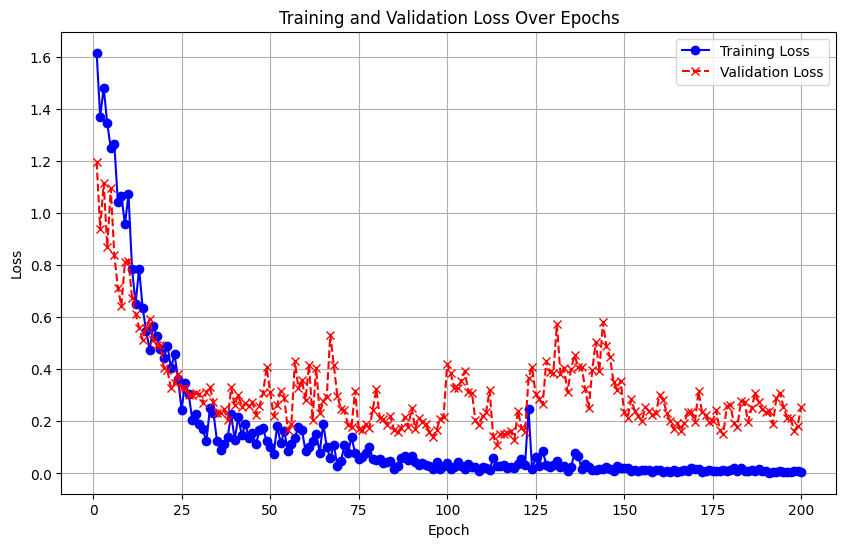

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Load and evaluate

In [ ]:
loaded_model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=4)
path_to_save = '/content/drive/MyDrive/output/ML_Task/resnet3d_ML_Task_V4_best_0.0002_SGD_best_on_min_val_loss.pt'

checkpoint = torch.load(path_to_save, map_location=torch.device('cpu'))
loaded_model.load_state_dict(checkpoint)
loaded_model.eval()

In [ ]:
def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['input'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate precision, recall, and accuracy
    precision = precision_score(all_labels, all_preds, average=None, zero_division=1)
    recall = recall_score(all_labels, all_preds, average=None)
    accuracy = accuracy_score(all_labels, all_preds)

    return cm, precision, recall, accuracy

# Example usage:
cm, precision, recall, accuracy = evaluate_model(loaded_model, val_loader)
print("Confusion Matrix:")
print(cm)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)


Confusion Matrix:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Precision: [1. 1. 1. 1.]
Recall: [1. 1. 1. 1.]
Accuracy: 1.0


### GradCAM

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0, shuffle=False)

In [ ]:
i=0

for batch in train_loader:
    inputs, labels = batch['input'], batch['label']
    if i==4:
      break
    i+=1
print(inputs.shape)
print(labels.shape)
print(labels)

torch.Size([1, 2, 64, 64, 64])
torch.Size([1])
tensor([1])


In [ ]:
import torch
from torch.nn import functional as F

def make_gradcam_heatmap(img_tensor, model, layer_num):
    """Generate class activation heatmap"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    with torch.enable_grad():
        features, outputs = model.grad_eval(img_tensor.to(device))
        _, pred_index = torch.max(outputs.data, 1)
        class_channel = outputs[:, pred_index]

        print('layer1',features[0].shape) # all nan in this layer
        print('layer2',features[1].shape)
        print('layer3',features[2].shape)
        print('layer4',features[3].shape)
        print('layer5',features[4].shape) # not working on this flat layer
        print('outputs',outputs)
        print(pred_index)
        print(class_channel)

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = torch.autograd.grad(outputs=class_channel, inputs=features[layer_num])[0]
    print('grads', grads.shape)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel (equivalent to global average pooling)
    pooled_grads = torch.mean(grads, dim=(2, 3, 4))
    print('pooled_grads', pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = features[layer_num].squeeze(0)
    heatmap = torch.matmul(last_conv_layer_output.permute(1, 2, 3, 0), pooled_grads.unsqueeze(-1))
    heatmap = heatmap.squeeze(-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # Notice that we clip the heatmap values, which is equivalent to applying ReLU
    heatmap = torch.maximum(heatmap, torch.tensor(0.0))
    heatmap /= torch.max(heatmap)
    return heatmap.cpu().detach().numpy()


In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(inputs.detach().cpu(), loaded_model, 2)
print('heatmap', heatmap.shape)

layer1 torch.Size([1, 64, 16, 16, 16])
layer2 torch.Size([1, 128, 8, 8, 8])
layer3 torch.Size([1, 256, 4, 4, 4])
layer4 torch.Size([1, 512, 2, 2, 2])
layer5 torch.Size([1, 512])
outputs tensor([[-2.0748,  6.0439, -0.5843, -2.6103]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.0439]], grad_fn=<IndexBackward0>)
grads torch.Size([1, 256, 4, 4, 4])
pooled_grads torch.Size([1, 256])
heatmap (4, 4, 4)


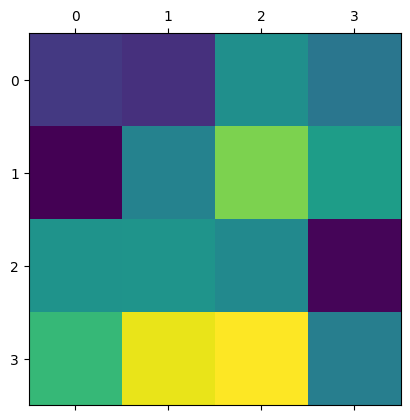

In [ ]:
plt.matshow(np.squeeze(heatmap[:, :, 0]))
plt.show()

In [ ]:
from scipy.ndimage import zoom

def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap


resized_heatmap = get_resized_heatmap(heatmap, inputs.shape[2:])
print(resized_heatmap.shape)

(64, 64, 64)


train data

Class label: tensor([1])



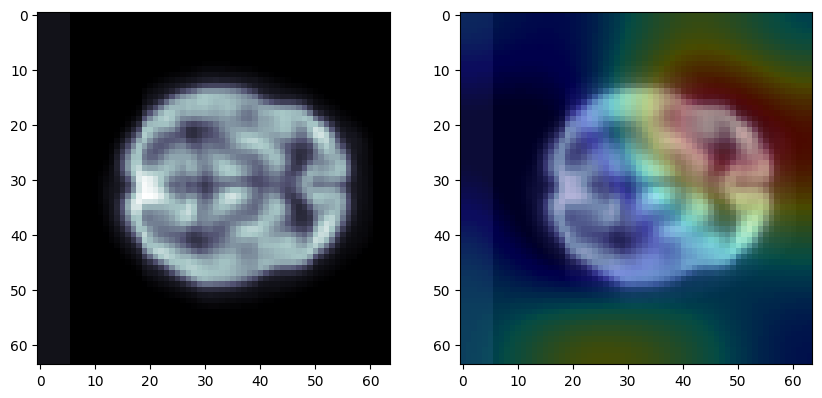

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
print(f"Class label: {labels}\n")
plt.show()

#### class 0 heatmaps

class 0 test data index 2

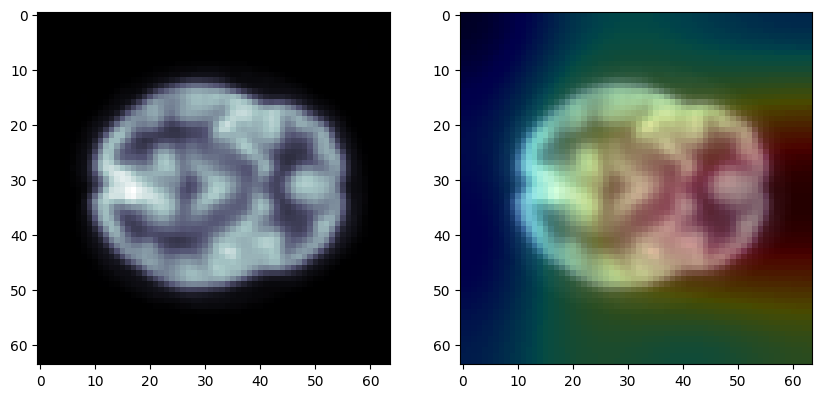

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

class 0 test data index 2

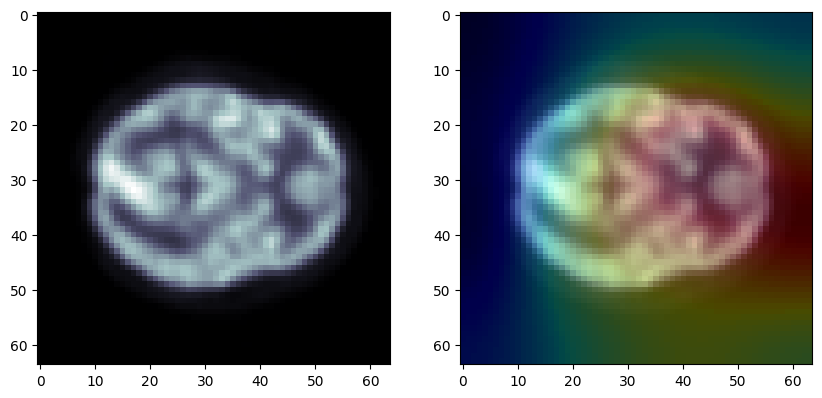

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

#### class 1 heatmaps

class 1 val data index 0

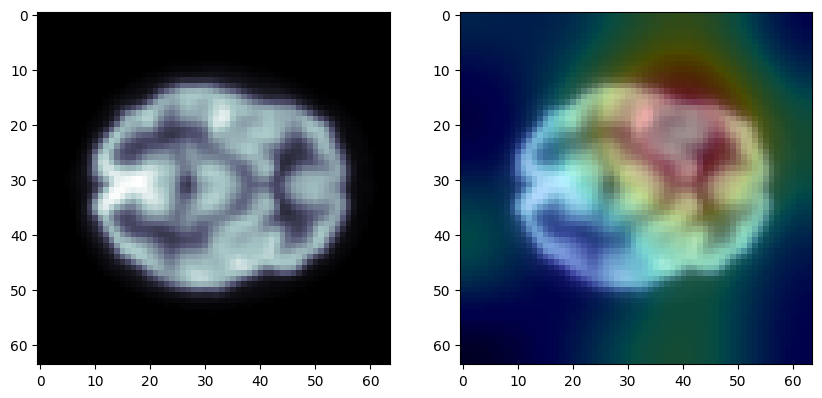

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

class 1 test data index 3

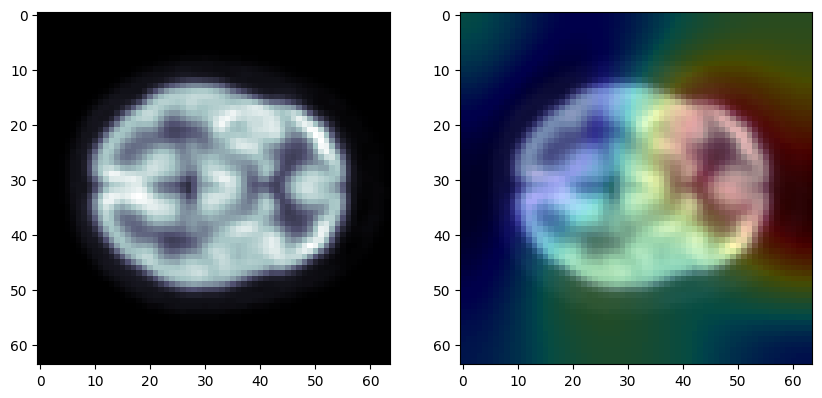

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

#### class 2 heatmaps

class 2 val data index 3

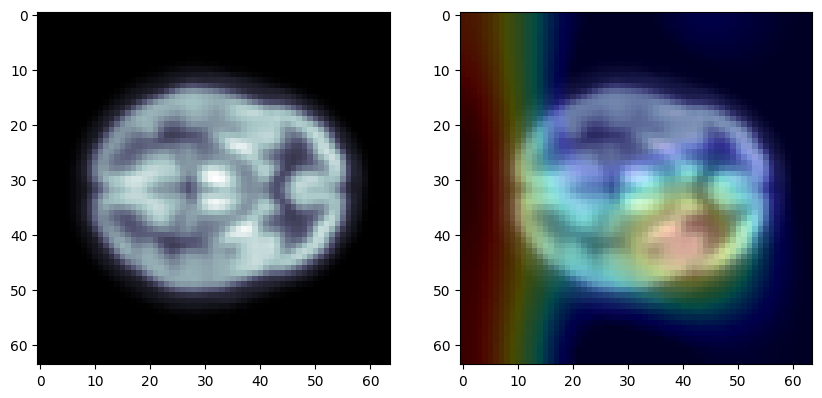

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

class 2 test data index 1

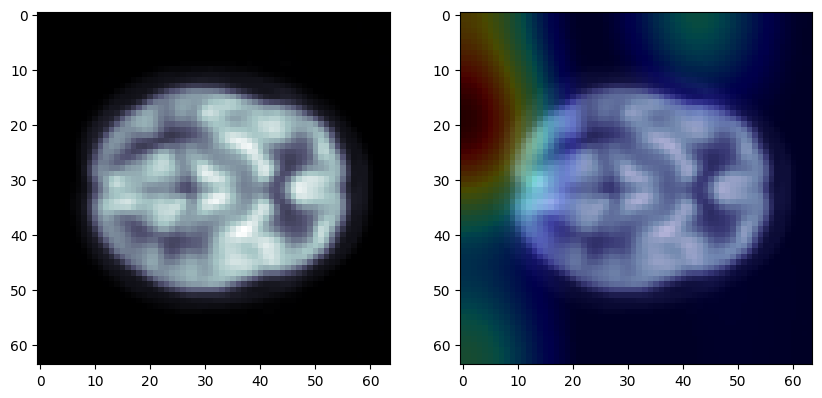

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

#### class 3 heatmaps

class 3 test data index 0

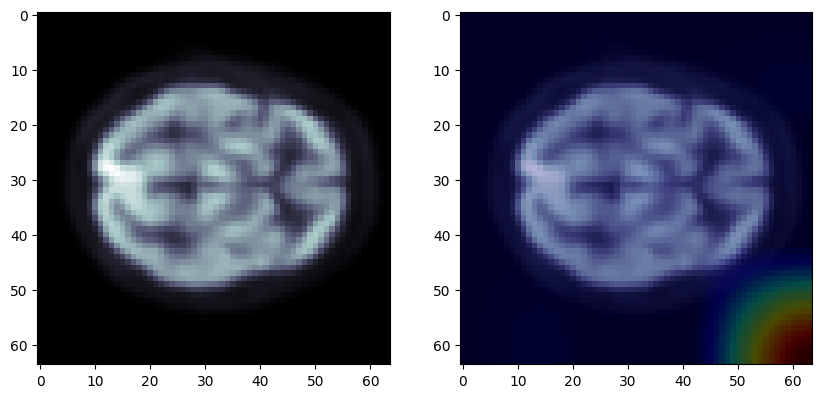

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

class 3 val data index 2

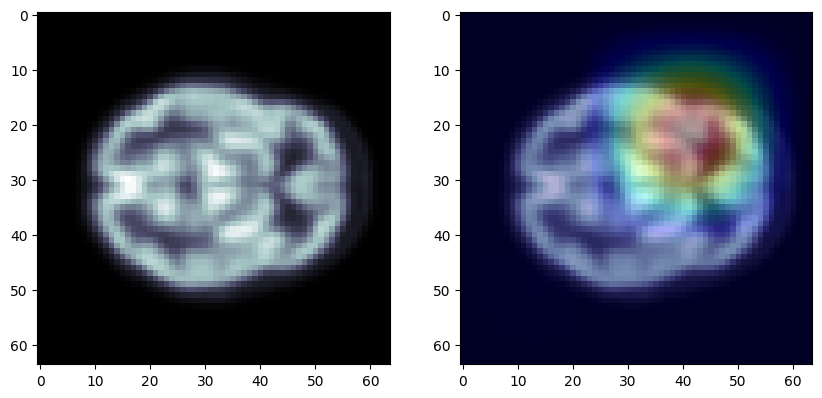

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

####Bounding Box

In [ ]:
import cv2
from matplotlib.patches import PathPatch, Rectangle


def get_bounding_boxes(heatmap, threshold=0.15, otsu=False):
    """Get bounding boxes from heatmap"""
    p_heatmap = np.copy(heatmap)

    if otsu:
        # Otsu's thresholding method to find the bounding boxes
        threshold, p_heatmap = cv2.threshold(
            heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    else:
        # Using a fixed threshold
        p_heatmap[p_heatmap < threshold * 255] = 0
        p_heatmap[p_heatmap >= threshold * 255] = 1

    # find the contours in the thresholded heatmap
    contours = cv2.findContours(p_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # get the bounding boxes from the contours
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        bboxes.append([x, y, x + w, y + h])

    return bboxes


def get_bbox_patches(bboxes, color='r', linewidth=2):
    """Get patches for bounding boxes"""
    patches = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        patches.append(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                edgecolor=color,
                facecolor='none',
                linewidth=linewidth,
            )
        )
    return patches

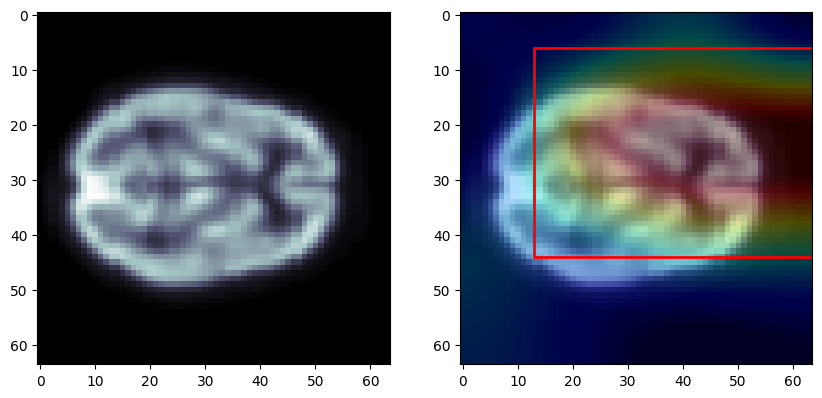

In [ ]:
# show the bounding boxes on the original image
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(inputs[0,0,:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())

bboxes = get_bounding_boxes(np.squeeze(resized_heatmap[:, :, 30]), threshold=0.4)
patches = get_bbox_patches(bboxes)

for patch in patches:
    ax[1].add_patch(patch)

plt.show()

####Interactive Slice Viewers

In [ ]:
from ipywidgets import IntSlider, interact
from matplotlib.path import Path

def _draw_line(ax, coords, clr='g'):
    line = Path(coords, [Path.MOVETO, Path.LINETO])
    pp = PathPatch(line, linewidth=3, edgecolor=clr, facecolor='none')
    ax.add_patch(pp)


def _set_axes_labels(ax, axes_x, axes_y):
    ax.set_xlabel(axes_x)
    ax.set_ylabel(axes_y)
    ax.set_aspect('equal', 'box')


def _draw_bboxes(ax, heatmap):
    bboxes = get_bounding_boxes(heatmap, otsu=True)
    patches = get_bbox_patches(bboxes)
    for patch in patches:
        ax.add_patch(patch)


_rec_prop = dict(linewidth=5, facecolor='none')


def show_volume(vol, z, y, x, heatmap=None, alpha=0.3, fig_size=(6, 6)):
    """Show a slice of a volume with optional heatmap"""
    fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=fig_size)
    v_z, v_y, v_x = vol.shape

    img0 = axarr[0, 0].imshow(vol[z, :, :], cmap='bone')
    if heatmap is not None:
        axarr[0, 0].imshow(
            heatmap[z, :, :], cmap='jet', alpha=alpha, extent=img0.get_extent()
        )
        _draw_bboxes(axarr[0, 0], heatmap[z, :, :])

    axarr[0, 0].add_patch(Rectangle((-1, -1), v_x, v_y, edgecolor='r', **_rec_prop))
    _draw_line(axarr[0, 0], [(x, 0), (x, v_y)], 'g')
    _draw_line(axarr[0, 0], [(0, y), (v_x, y)], 'b')
    _set_axes_labels(axarr[0, 0], 'X', 'Y')

    img1 = axarr[0, 1].imshow(vol[:, :, x].T, cmap='bone')
    if heatmap is not None:
        axarr[0, 1].imshow(
            heatmap[:, :, x].T, cmap='jet', alpha=alpha, extent=img1.get_extent()
        )
        _draw_bboxes(axarr[0, 1], heatmap[:, :, x].T)

    axarr[0, 1].add_patch(Rectangle((-1, -1), v_z, v_y, edgecolor='g', **_rec_prop))
    _draw_line(axarr[0, 1], [(z, 0), (z, v_y)], 'r')
    _draw_line(axarr[0, 1], [(0, y), (v_x, y)], "b")
    _set_axes_labels(axarr[0, 1], 'Z', 'Y')

    img2 = axarr[1, 0].imshow(vol[:, y, :], cmap='bone')
    if heatmap is not None:
        axarr[1, 0].imshow(
            heatmap[:, y, :], cmap='jet', alpha=alpha, extent=img2.get_extent()
        )
        _draw_bboxes(axarr[1, 0], heatmap[:, y, :])

    axarr[1, 0].add_patch(Rectangle((-1, -1), v_x, v_z, edgecolor='b', **_rec_prop))
    _draw_line(axarr[1, 0], [(0, z), (v_x, z)], 'r')
    _draw_line(axarr[1, 0], [(x, 0), (x, v_y)], 'g')
    _set_axes_labels(axarr[1, 0], 'X', 'Z')
    axarr[1, 1].set_axis_off()
    fig.tight_layout()


def interactive_show(volume, heatmap=None):
    """Show a volume interactively"""
    # transpose volume from (x, y, z) to (z, y, x)
    volume = np.transpose(volume, (2, 0, 1))
    if heatmap is not None:
        heatmap = np.transpose(heatmap, (2, 0, 1))
    vol_shape = volume.shape

    interact(
        lambda x, y, z: plt.show(show_volume(volume, z, y, x, heatmap)),
        z=IntSlider(min=0, max=vol_shape[0] - 1, step=1, value=int(vol_shape[0] / 2)),
        y=IntSlider(min=0, max=vol_shape[1] - 1, step=1, value=int(vol_shape[1] / 2)),
        x=IntSlider(min=0, max=vol_shape[2] - 1, step=1, value=int(vol_shape[2] / 2)),
    )

In [ ]:
interactive_show(inputs[0,0,:, :, :], heatmap=resized_heatmap)

interactive(children=(IntSlider(value=32, description='x', max=63), IntSlider(value=32, description='y', max=6…

####Animation

In [ ]:
from matplotlib import animation, rc


rc('animation', html='jshtml')


def create_animation(array, case, heatmap=None, alpha=0.3, thresh=0.4):
    """Create an animation of a volume"""
    array = np.transpose(array, (2, 0, 1))
    if heatmap is not None:
        heatmap = np.transpose(heatmap, (2, 0, 1))
    fig = plt.figure(figsize=(4, 4))
    images = []
    for idx, image in enumerate(array):
        # plot image without notifying animation
        image_plot = plt.imshow(image, animated=True, cmap='bone')
        aux = [image_plot]
        if heatmap is not None:
            image_plot2 = plt.imshow(
                heatmap[idx], animated=True, cmap='jet', alpha=alpha, extent=image_plot.get_extent())
            aux.append(image_plot2)

            # add bounding boxes to the heatmap image as animated patches
            bboxes = get_bounding_boxes(heatmap[idx], threshold=thresh)
            patches = get_bbox_patches(bboxes)
            aux.extend(image_plot2.axes.add_patch(patch) for patch in patches)
        images.append(aux)

    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.title(f'Patient ID: {case}', fontsize=16)
    ani = animation.ArtistAnimation(
        fig, images, interval=5000//len(array), blit=False, repeat_delay=1000)
    plt.close()
    return ani

In [ ]:
create_animation(inputs[0,0,:, :, :], 'Test')

In [ ]:
create_animation(inputs[0,0,:, :, :], 'Test', heatmap=resized_heatmap, thresh=0.4)

### Predict on test and save to file

#### Load the test data

In [ ]:
# path to train datasets, labels and VoI template files

test_rCBF = Path("/content/drive/MyDrive/Assignment/test_images_rcbf.nii")
test_DAT = Path("/content/drive/MyDrive/Assignment/test_images_sbr.nii")

In [ ]:
# Load NIfTI and extract image data

test_PET_rCBF = nib.load(test_rCBF)
test_data_rCBF = test_PET_rCBF.get_fdata()

test_PET_DAT = nib.load(test_DAT)
test_data_DAT = test_PET_DAT.get_fdata()

#### Dataset creation and normalization

In [ ]:
tdata = create_xdata(test_data_rCBF, test_data_DAT)
print(tdata.shape)

(41, 2, 64, 64, 64)


In [ ]:
test_dataset = CustomDataset(tdata, np.zeros((tdata.shape[0])) , transform=val_transforms)  # Apply validation transformation

print(f"There are {len(test_dataset)} test images")

There are 41 test images


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False)
print('test dataset', np.unique(test_dataset.labels, return_counts=True))

test dataset (array([0.]), array([41]))


#### Load model and make predictions

In [ ]:
loaded_model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=4)
path_to_save = '/content/drive/MyDrive/output/ML_Task/resnet3d_ML_Task_V4_best_0.0002_SGD_best_on_min_val_loss.pt'

checkpoint = torch.load(path_to_save, map_location=torch.device('cpu'))
loaded_model.load_state_dict(checkpoint)
loaded_model.eval()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)


loaded_model.eval()  # Set model to evaluation mode

preds = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['input'].to(device), batch['label'].to(device)
        outputs = loaded_model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        preds.append(predicted.cpu())

print(len(preds))

41


In [ ]:
np_preds = np.array(preds).squeeze()+1
print(np_preds.shape)

(41,)


In [ ]:
print(np_preds)

[2 2 3 1 1 1 2 2 3 2 3 1 2 1 2 4 1 1 1 3 1 3 3 2 3 3 3 2 2 2 1 3 2 1 1 3 3
 1 1 3 4]


#### save to file

In [ ]:
# Save the DataFrame to a CSV file, including patient number

index_array = np.arange(1, np_preds.shape[0] + 1)
combined_array = np.column_stack((index_array, np_preds))

df = pd.DataFrame(combined_array, columns=['patient_number', 'ResNet_predication'])
df.to_csv("patient_predictions.csv", index=False)
